In [29]:
import numpy as np
import matplotlib.pyplot as plt
import gzip
import pickle
from tqdm import tqdm


In [2]:
class Activation:
    def __init__(self, method):
        self.method = method
        self.activate = self.get_activation_function(method)
        self.derive = self.get_derivative_function(method)

    def get_activation_function(self, method):
        activations = {
            'linear': self.linear,
            'relu': self.relu,
            'sigmoid': self.sigmoid,
            'tanh': self.tanh,
            'softmax': self.softmax
        }
        if method not in activations:
            raise ValueError(f"Unknown activation method: {method}")
        return activations[method]

    def get_derivative_function(self, method):
        derivatives = {
            'linear': self.linear_derivative,
            'relu': self.relu_derivative,
            'sigmoid': self.sigmoid_derivative,
            'tanh': self.tanh_derivative,
            'softmax': self.softmax_derivative
        }
        if method not in derivatives:
            raise ValueError(f"Unknown activation method: {method}")
        return derivatives[method]

    def linear(self, x):
        return x

    def linear_derivative(self, x):
        return np.ones_like(x)

    def relu(self, x):
        return np.maximum(0, x)

    def relu_derivative(self, x):
        # print("envoked relu_derivative")
        return (x > 0).astype(float)
    

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def sigmoid_derivative(self, x):
        sig = self.sigmoid(x)
        return sig * (1 - sig)

    def tanh(self, x):
        return np.tanh(x)

    def tanh_derivative(self, x):
        return 1 - np.tanh(x) ** 2

    def softmax(self, x):
        # print("envoked softmax derivative")
        exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))  
        return exp_x / np.sum(exp_x, axis=1, keepdims=True)

    def softmax_derivative(self, x):
        return x * (1 - x)

In [ ]:
class LossFunction:
    def __init__(self, method):
        self.method = method
        self.compute = self.get_loss_function(method)
        self.derive = self.get_derivative_function(method)

    def get_loss_function(self, method):
        losses = {
            'mse': self.mse,
            'cce': self.cce,
            'bce': self.bce
        }
        if method not in losses:
            raise ValueError(f"Unknown loss function: {method}")
        return losses[method]

    def get_derivative_function(self, method):
        derivatives = {
            'mse': self.mse_derivative,
            'cce': self.cce_derivative,
            'bce': self.bce_derivative
        }
        if method not in derivatives:
            raise ValueError(f"Unknown loss function: {method}")
        return derivatives[method]

    def mse(self, y_true, y_pred):
        return np.mean(np.square(y_true - y_pred))

    def mse_derivative(self, y_true, y_pred):
        return y_pred - y_true  

    def cce(self, y_true, y_pred):
        return -np.sum(y_true * np.log(y_pred + 1e-8)) / y_true.shape[0]

    def cce_derivative(self, y_true, y_pred):
        return y_pred - y_true 

    def bce(self, y_true, y_pred):
        return -np.mean(y_true * np.log(y_pred + 1e-8) + (1 - y_true) * np.log(1 - y_pred + 1e-8))

    def bce_derivative(self, y_true, y_pred):
        return (y_pred - y_true) / (y_pred * (1 - y_pred) + 1e-8)  


In [ ]:
class WeightInit:
    @staticmethod
    def zeros(size,seed=42):
        return np.zeros(size)  

    @staticmethod
    def random_uniform(size, low=-1, high=1, seed=42):
        np.random.seed(seed)
        return np.random.uniform(low, high, size) 

    @staticmethod
    def random_normal(size, mean=0, std=1, seed=42):
        np.random.seed(seed)
        return np.random.normal(mean, std, size)  

    @staticmethod
    def xavier_uniform(size, seed=42):
        np.random.seed(seed)
        limit = np.sqrt(6 / size[0])  
        return np.random.uniform(-limit, limit, size)  

    @staticmethod
    def xavier_normal(size, seed=42):
        np.random.seed(seed)
        std = np.sqrt(2 / size[0])
        return np.random.normal(0, std, size)  

    @staticmethod
    def he_uniform(size, seed=42):
        np.random.seed(seed)
        limit = np.sqrt(6 / size[0])
        return np.random.uniform(-limit, limit, size)  

    @staticmethod
    def he_normal(size, seed=42):
        np.random.seed(seed)
        std = np.sqrt(2 / size[0])
        return np.random.normal(0, std, size) 


In [ ]:
class Layer:
    def __init__(self, input_size, n_neurons, activation, 
                 weight_init='random_normal', bias_init='zeros', 
                 seed=42, **kwargs):

        self.input_size = input_size
        self.n_neurons = n_neurons
        self.activation = Activation(activation)  
        self.seed = seed
        self.weights = self.initialize_weights(weight_init, seed, **kwargs)
        self.biases = self.initialize_biases(bias_init, seed, **kwargs)

    def initialize_weights(self, method, seed, **kwargs):
        if hasattr(WeightInit, method):
            return getattr(WeightInit, method)(size=(self.input_size, self.n_neurons), seed=seed, **kwargs)  
        else:
            raise ValueError(f"init bobot tidak diketahui: {method}")

    def initialize_biases(self, method, seed, **kwargs):
        if hasattr(WeightInit, method):
            return getattr(WeightInit, method)(size=(1, self.n_neurons), seed=seed, **kwargs)  
        else:
            raise ValueError(f"init bias tidak diketahui: {method}")


class MLP:
    def __init__(self, layers,loss_function, lr=0.01):
        
        self.lr = lr
        self.num_layers = len(layers)
        self.layers = layers
        self.loss_function = LossFunction(loss_function)
        self.loss_graph = []
        self.valid_graph = []
    def forward(self, X):
        self.activations = [X]

        for i in range(self.num_layers):
            z = np.dot(self.activations[-1], self.layers[i].weights) + self.layers[i].biases
            a = self.layers[i].activation.activate(z)
            self.activations.append(a)

        return a
    def backward(self, X, y_true):
        m = X.shape[0]
        y_pred = self.activations[-1]

        if self.loss_function.method == 'mse':
            # perkalian turunan rantai
            delta = self.loss_function.derive(y_true, y_pred) * self.layers[-1].activation.derive(y_pred)
        elif self.loss_function.method in ['cce', 'bce']: 
            # khasus khusus untuk cce + softmax, atau bce + sigmoid, pakai turunan langsung
            delta = self.loss_function.derive(y_true, y_pred)

        errors = [delta]  

        # backprop
        for i in range(self.num_layers - 1, 0, -1):
            # print(f"Layer {i} - Activation: {self.layers[i-1].activation.method}")
            # dA = error dari layer di atas, dikali turunan aktivasi dari layer ini
            dA = np.dot(errors[-1], self.layers[i].weights.T)  
            delta = dA * self.layers[i-1].activation.derive(self.activations[i])  
            errors.append(delta)

        errors.reverse()  # Urutkan dari input → output

        # grad descent
        for i in range(self.num_layers):
            dW = (1 / m) * np.dot(self.activations[i].T, errors[i])
            db = (1 / m) * np.sum(errors[i], axis=0, keepdims=True)

            self.layers[i].weights -= self.lr * dW
            self.layers[i].biases -= self.lr * db
        
    # print("backward pass done")


    def compute_loss(self, y_true, y_pred):
        return -np.mean(np.sum(y_true * np.log(y_pred + 1e-8), axis=1))


    def train(self, X, y, X_val=None, y_val=None, epochs=10, batch_size=64):   
        progress_bar = tqdm(total=epochs, desc="Training", unit="epoch", position=0, leave=True)  
        m = X.shape[0]

        for epoch in range(epochs):
            perm = np.random.permutation(m)
            X_shuffled = X[perm]
            y_shuffled = y[perm]

            # Mini batch
            for i in range(0, m, batch_size):
                X_batch = X_shuffled[i:i+batch_size]
                y_batch = y_shuffled[i:i+batch_size]

                y_pred = self.forward(X_batch)
                self.backward(X_batch, y_batch)

            # Hitung training loss & accuracy
            y_pred_train = self.forward(X)
            loss_train = self.compute_loss(y, y_pred_train)
            acc_train = self.accuracy(X, y)
            self.loss_graph.append(loss_train)

            # Hitung validation loss hanya jika X_val & y_val diberikan
            if X_val is not None and y_val is not None:
                y_pred_val = self.forward(X_val)
                loss_val = self.compute_loss(y_val, y_pred_val)
                self.valid_graph.append(loss_val)
                progress_bar.set_postfix(train_loss=f"{loss_train:.4f}", 
                                        val_loss=f"{loss_val:.4f}", 
                                        accuracy=f"{acc_train:.2f}%")
            else:
                progress_bar.set_postfix(train_loss=f"{loss_train:.4f}", 
                                        accuracy=f"{acc_train:.2f}%")

            progress_bar.update(1)  

        progress_bar.close()  



    def accuracy(self, X, y_true):
        y_pred = self.forward(X)
        y_pred_classes = np.argmax(y_pred, axis=1)
        y_true_classes = np.argmax(y_true, axis=1)
        return np.mean(y_pred_classes == y_true_classes) * 100

    def predict(self, X):
        return np.argmax(self.forward(X), axis=1)

    def plot_loss(self):
        plt.plot(self.loss_graph, label="Training Loss",color = "red")
        plt.plot(self.valid_graph,label = "Validation Loss",color = "blue")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()
        plt.show()

In [ ]:
import openml

# Load dataset MNIST dari OpenML
mnist = openml.datasets.get_dataset(554)  # ID 554 = MNIST
X, y, _, _ = mnist.get_data(target=mnist.default_target_attribute)

# Konversi ke NumPy array
X = X.to_numpy() / 255.0  # Normalisasi 0-1
y = y.astype(int).to_numpy()  # Pastikan label integer

# One-hot encoding label
def one_hot(y, num_classes=10):
    one_hot_encoded = np.zeros((y.shape[0], num_classes))
    one_hot_encoded[np.arange(y.shape[0]), y] = 1
    return one_hot_encoded

y = one_hot(y)

num_data = 60000

# Split data (60,000 train, 10,000 test)
X_train, X_test = X[:num_data], X[num_data:]
y_train, y_test = y[:num_data], y[num_data:]

print(f"Dataset loaded: {X_train.shape[0]} training samples, {X_test.shape[0]} test samples.")

In [19]:
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

mnist = fetch_openml('mnist_784', version=1, parser='auto')

X, y = mnist.data, mnist.target.astype(int)
X = X.to_numpy() / 255.0  
y = y.astype(int).to_numpy()  
def one_hot(y, num_classes=10):
    one_hot_encoded = np.zeros((y.shape[0], num_classes))
    one_hot_encoded[np.arange(y.shape[0]), y] = 1
    return one_hot_encoded

y = one_hot(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=10000, random_state=42)
print(f"Dataset loaded: {X_train.shape[0]} training samples, {X_test.shape[0]} test samples.")


Dataset loaded: 60000 training samples, 10000 test samples.


In [ ]:
# Buat model
input_layer = Layer(input_size=784, n_neurons=8, activation='relu', bias_init='zeros',seed=42,weight_init='he_uniform')
hidden_layer_1 = Layer(input_size=8, n_neurons=8, activation='relu', bias_init='zeros',seed=42,weight_init='he_uniform')
hidden_layer_2 = Layer(input_size=8, n_neurons=4, activation='relu', bias_init='zeros',seed=42,weight_init='he_uniform')
output_layer = Layer(input_size=4, n_neurons=10, activation='softmax', bias_init='zeros',seed=42,weight_init='he_uniform')

layers = [input_layer, hidden_layer_1, hidden_layer_2,output_layer]

mlp = MLP(layers=layers, loss_function='cce',lr=0.1)

# Training model
mlp.train(X_train, y_train,X_val=X_test,y_val=y_test ,epochs=10, batch_size=100)

# Evaluasi di test set
test_acc = mlp.accuracy(X_test, y_test)
print(f"Test Accuracy: {test_acc:.2f}%")

Training: 100%|██████████| 10/10 [00:06<00:00,  1.65epoch/s, accuracy=89.43%, train_loss=0.4133, val_loss=0.4621]

Test Accuracy: 88.26%


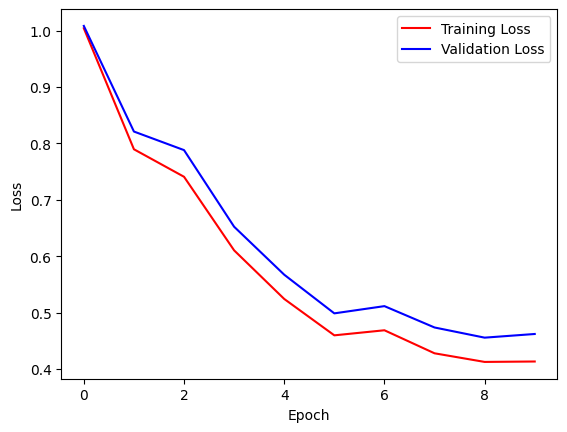

In [ ]:
mlp.plot_loss()

Training:  76%|███████▌  | 76/100 [06:20<02:00,  5.01s/epoch, accuracy=55.88%, train_loss=1.2859]

Dimensi y_pred: (20,)


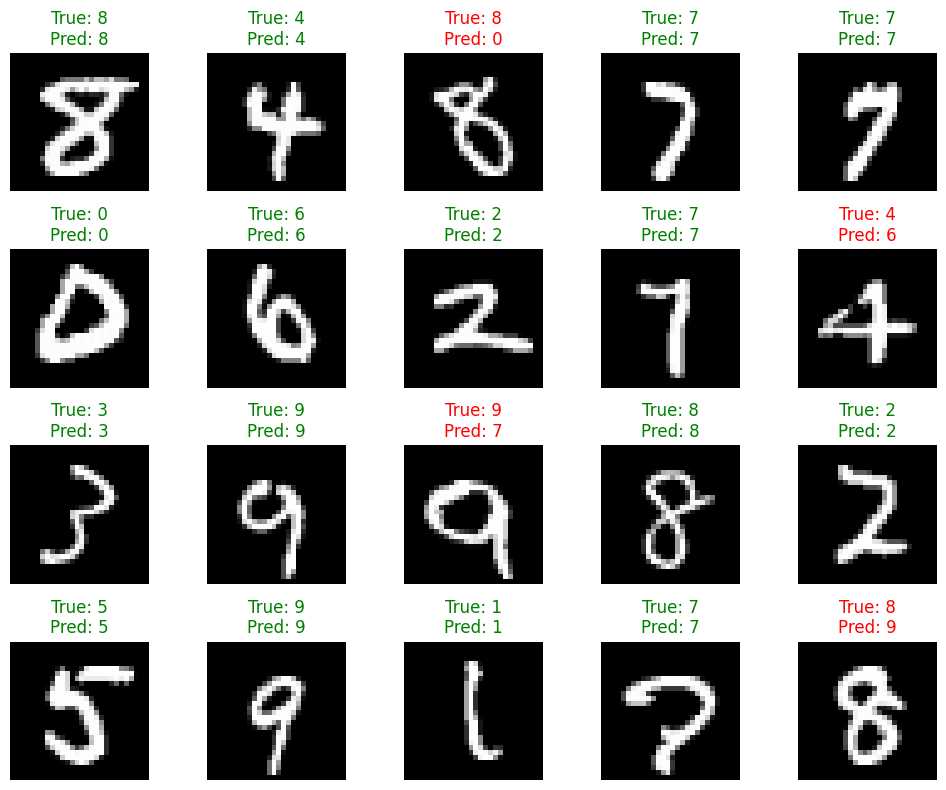

In [ ]:
sample_size = 20

X_sample = X_test[:sample_size]
y_sample = y_test[:sample_size]

y_pred = mlp.predict(X_sample)

print(f"Dimensi y_pred: {y_pred.shape}")

# Konversi hasil prediksi ke label (ambil indeks dengan probabilitas tertinggi)
if len(y_pred.shape) > 1:
    y_pred_labels = np.argmax(y_pred, axis=1)
else:
    y_pred_labels = y_pred 

y_true_labels = np.argmax(y_sample, axis=1)  # Karena label asli one-hot

# Plot hasilnya
fig, axes = plt.subplots(4, 5, figsize=(10, 8))
axes = axes.flatten()

for i, ax in enumerate(axes):
    ax.imshow(X_sample[i].reshape(28, 28), cmap="gray")
    ax.set_title(f"True: {y_true_labels[i]}\nPred: {y_pred_labels[i]}", color="green" if y_true_labels[i] == y_pred_labels[i] else "red")
    ax.axis("off")

plt.tight_layout()
plt.show()